## Package Import

In [1]:
import os 
import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix

import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import SGD

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import random
from matplotlib import pyplot as plt


/opt/conda/envs/recbole/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Preprocess

In [8]:
dpath = 'archive-2'
data_list = []
for i in os.listdir(dpath):
    if 'combined_data' in i:
        data_list.append(i)
data_list

['combined_data_1.txt',
 'combined_data_3.txt',
 'combined_data_2.txt',
 'combined_data_4.txt']

In [9]:
df = pd.DataFrame({'Cust_ID','Rating','Timestamp'}) 

for data in data_list:
    temp_df = pd.read_csv(os.path.join(dpath, data), header = None, names = ['Cust_ID', 'Rating','Timestamp'], usecols = [0,1,2])
    temp_df['Rating'] = temp_df['Rating'].astype(float)
    df = pd.concat([df, temp_df])
    print("Loaded: ", data)

df.index = np.arange(0,len(df))

Loaded:  combined_data_1.txt
Loaded:  combined_data_3.txt
Loaded:  combined_data_2.txt
Loaded:  combined_data_4.txt


In [10]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Rating
0,0,True
1,1,True
2,2,True
3,3,True
4,551,True
...,...,...
17768,100488434,True
17769,100489040,True
17770,100489245,True
17771,100490608,True


In [12]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [4.0000e+00 4.0000e+00 4.0000e+00 ... 1.7773e+04 1.7773e+04 1.7773e+04]
Length: 100480507


In [13]:
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_ID'] = df['Cust_ID'].astype(int)
print(df.iloc[::5000000, :])

             0  Cust_ID  Rating   Timestamp  Movie_Id
4          NaN  1488844     3.0  2005-09-06         4
5000999    NaN   501954     2.0  2004-08-26       999
10001965   NaN   404654     5.0  2005-08-29      1965
15002879   NaN   886608     2.0  2005-09-19      2879
20003828   NaN  1193835     2.0  2003-08-13      3828
25004725   NaN    35179     4.0  2004-05-17      4725
30005671   NaN  2561536     3.0  2002-09-23      5671
35006571   NaN   200362     4.0  2005-02-28      6571
40007524   NaN   686629     4.0  2005-03-01      7524
45008342   NaN  1494017     2.0  2003-07-04      8342
50009229   NaN   437784     4.0  2005-07-30      9229
55010055   NaN   788058     4.0  2005-09-29     10055
60010827   NaN   433661     4.0  2002-01-18     10827
65011673   NaN  2402781     4.0  2004-11-10     11673
70012701   NaN   182620     4.0  2004-12-08     12701
75013585   NaN   506044     4.0  2004-09-28     13585
80014456   NaN   353605     2.0  2005-07-10     14456
85015119   NaN   664606     

In [15]:
df = df[['Cust_ID', 'Movie_Id', 'Rating','Timestamp']]

user2idx = {j:i for i,j in enumerate(df['Cust_ID'].unique())}
item2idx = {j:i for i,j in enumerate(df['Movie_Id'].unique())}
df['Cust_ID'] = df['Cust_ID'].map(user2idx)
df['Movie_Id'] = df['Movie_Id'].map(item2idx)
df

/tmp/ipykernel_21746/1478047817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_ID'] = df['Cust_ID'].map(user2idx)
/tmp/ipykernel_21746/1478047817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = df['Movie_Id'].map(item2idx)


,Cust_ID,Movie_Id,Rating,Timestamp
4,0,0,3.0,2005-09-06
5,1,0,5.0,2005-05-13
6,2,0,4.0,2005-10-19
7,3,0,4.0,2005-12-26
8,4,0,3.0,2004-05-03
...,...,...,...,...
100498275,542,17769,4.0,2005-11-01
100498276,29273,17769,3.0,2005-07-19
100498277,29251,17769,1.0,2004-08-07
100498278,22793,17769,4.0,2004-05-28


In [16]:
df.to_csv('preprocessed_df_with_timestamp.csv', index=False)

## MF

In [2]:
df = pd.read_csv('preprocessed_df_with_timestamp.csv')

In [18]:
def predict(P, Q, mu, b_u, b_i, user, item):
    pred = mu + b_u[user] + b_i[item] + P[user, :].T.dot(Q[item, :])
    return pred

In [19]:
def sgd(P, Q, mu, b_u, b_i, samples, lr, reg):
    for user, item, rating in samples:
        pred = predict(P, Q, mu, b_u, b_i, user, item)
        
        error = rating - pred
        
        b_u[user] += lr * (error - reg * b_u[user])
        b_i[item] += lr * (error - reg * b_i[item])
        
        P[user, :] += lr * (error * Q[item, :] - reg * P[user, :])
        Q[item, :] += lr * (error * P[user, :] - reg * Q[item, :])

In [20]:
def rmse(samples, P, Q, mu, b_u, b_i):
    error = [] 
    for user,item,rating in samples:
        square_error = (rating - predict(P, Q, mu, b_u, b_i, user, item))**2
        error.append(square_error)
    rmse = np.sqrt(np.array(error).mean())
    return rmse

In [53]:
class MF_with_sgd(object):
    
    def __init__(self, df ,num_users, num_items, F, lr, reg, epochs):
        self.df = df
        self.num_users, self.num_items = num_users, num_items
        self.F = F
        self.lr = lr 
        self.reg = reg 
        self.epochs = epochs
        
        self.summary = pd.DataFrame(columns = ['epoch','rmse'])
        
    def build_samples(self): 
        
        self.samples = [] 
        self.users = self.df['Cust_ID'].values 
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        for idx in range(len(self.df)):
            if (idx % 10000000) == 0: 
                print(f"Loaded: {idx}th sample")
            self.samples.append((self.users[idx],self.items[idx],self.ratings[idx]))
    
    def train(self): 
        self.P = np.random.normal(scale = 1/self.F,size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F,size = (self.num_items, self.F))
        
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        
        self.mu = self.df['Rating'].mean()
        
        self.samples = self.samples[:10000000]
        for epoch in range(self.epochs): 
            print(f"Start: {epoch}th epoch")
            np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.mu, self.b_u, self.b_i, self.samples, self.lr, self.reg)
            loss = rmse(self.samples, self.P, self.Q, self.mu, self.b_u, self.b_i)
            print(f"Epoch: {epoch} ; error = {loss}")
            self.summary.loc[epoch] = [epoch, loss]
            

In [54]:
K = 10 
lr = 0.01 
reg = 0.2 
epochs = 30 

user_num = df['Cust_ID'].nunique()
item_num = df['Movie_Id'].nunique()

mf = MF_with_sgd(df,user_num,item_num, K, lr, reg, epochs)
mf.build_samples()

Loaded: 0th sample
Loaded: 10000000th sample
Loaded: 20000000th sample
Loaded: 30000000th sample
Loaded: 40000000th sample
Loaded: 50000000th sample
Loaded: 60000000th sample
Loaded: 70000000th sample
Loaded: 80000000th sample
Loaded: 90000000th sample
Loaded: 100000000th sample


In [55]:
mf.train()

Start: 0th epoch
Epoch: 0 ; error = 0.9572316469694094
Start: 1th epoch
Epoch: 1 ; error = 0.9397509040615157
Start: 2th epoch
Epoch: 2 ; error = 0.9314324950641998
Start: 3th epoch
Epoch: 3 ; error = 0.9270099889285239
Start: 4th epoch
Epoch: 4 ; error = 0.9224233657054468
Start: 5th epoch
Epoch: 5 ; error = 0.9205277940045398
Start: 6th epoch
Epoch: 6 ; error = 0.9186038999752827
Start: 7th epoch
Epoch: 7 ; error = 0.9176232089183574
Start: 8th epoch
Epoch: 8 ; error = 0.9158445003121978
Start: 9th epoch
Epoch: 9 ; error = 0.9149430735985525
Start: 10th epoch
Epoch: 10 ; error = 0.9137905380706801
Start: 11th epoch
Epoch: 11 ; error = 0.913244668978982
Start: 12th epoch
Epoch: 12 ; error = 0.9128372666927342
Start: 13th epoch
Epoch: 13 ; error = 0.9126737849916143
Start: 14th epoch
Epoch: 14 ; error = 0.9121091712182122
Start: 15th epoch
Epoch: 15 ; error = 0.9110212450433007
Start: 16th epoch
Epoch: 16 ; error = 0.9110054170528965
Start: 17th epoch
Epoch: 17 ; error = 0.910586942905

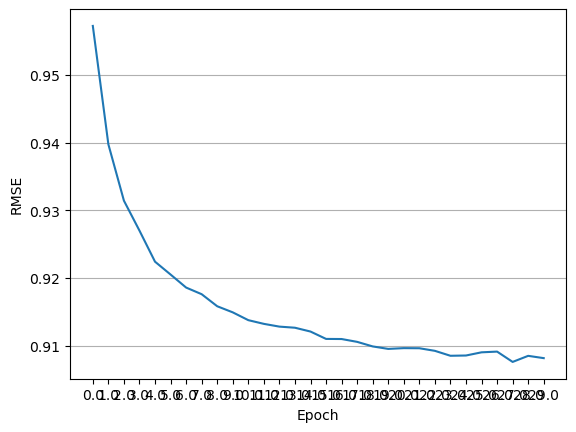

In [56]:
result_df = mf.summary 

x = result_df['epoch'].values
y = result_df['rmse'].values

plt.plot(x, y)
plt.xticks(x,x)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(axis = 'y')
plt.show()

## ALS

In [154]:
def als(R, P, Q, F, reg):
    for user in range(R.shape[0]):
        QT_Q = np.matmul(Q.T, Q)
        li = reg * np.eye(F)
        QT_ru = np.matmul(Q.T,R[user].toarray()[0])
        P[user] = np.linalg.solve(QT_Q + li,QT_ru)
        
    for item in range(R.shape[1]):
        PT_P = np.matmul(P.T, P)
        li = reg * np.eye(F)
        PT_ri = np.matmul(P.T,R[:,item].toarray())
        Q[item] = np.linalg.solve(PT_P + li,PT_ri).reshape(-1)

In [155]:
def als_loss(sample, R, P, Q, reg):
    loss = 0
    for user, item, rating in sample: 
        loss += (rating - np.matmul(P[user],Q[item]))**2
    for user in range(R.shape[0]):
        loss += reg * np.matmul(P[user],P[user])
    for item in range(R.shape[1]):
        loss += reg * np.matmul(Q[item],Q[item])
        
    return loss

In [163]:
class MF_with_als(object):
    def __init__(self, df, R, F, reg, epochs):
        self.df = df
        self.R = R
        self.num_users, self.num_items = R.shape 
        self.F = F 
        self.reg = reg 
        self.epochs = epochs 
        
        self.summary = pd.DataFrame(columns = ['epoch','loss'])
    
    def build_samples(self):
        self.samples = []
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        for idx in range(len(self.df)):
            if (idx % 10000000) == 0:
                print(f"Loaded: {idx}th sample")
            self.samples.append((self.users[idx],self.items[idx],self.ratings[idx]))
                
    def train(self):
        self.P = np.random.normal(scale = 1/self.F, size = (self.num_users, self.F))
        self.Q = np.random.normal(scale = 1/self.F, size = (self.num_items, self.F))
            
        for epoch in range(self.epochs): 
            print(f'Start: {epoch}th epoch')
            als(self.R, self.P, self.Q, self.F, self.reg)
            loss = als_loss(self.samples, self.R, self.P, self.Q, self.reg)
            print(f'Epoch: {epoch} ; loss = {loss}')
            self.summary.loc[epoch] = [epoch, loss]
            
    

In [161]:
als_df = df.iloc[:10000000]
als_df_user2idx = {user:idx for idx, user in enumerate(als_df['Cust_ID'].unique())}
als_df_item2idx = {item:idx for idx, item in enumerate(als_df['Movie_Id'].unique())}
als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)

/tmp/ipykernel_20511/902390691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Cust_ID'] = als_df['Cust_ID'].map(als_df_user2idx)
/tmp/ipykernel_20511/902390691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  als_df['Movie_Id'] = als_df['Movie_Id'].map(als_df_item2idx)


In [162]:
R = csr_matrix(
    (np.array(als_df['Rating'].values, dtype = np.int32),
    (np.array(als_df['Cust_ID'].values, dtype = np.int32),np.array(als_df['Movie_Id'].values, dtype = np.int32))
    ))

F = 10 
reg = 0.2
epochs = 500 

In [164]:
MF_als = MF_with_als(als_df, R, F, reg, epochs)
MF_als.build_samples()

Loaded: 0th sample


In [ ]:
MF_als.train()

## Pytorch Implementation

### Training Setting

In [3]:
class Netflix(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        rating = self.ratings[index]
        
        return user, item, rating

In [60]:
sample_df = df.loc[(df['Cust_ID'] < 1000) & (df['Movie_Id'] < 500)]
sample_df

,Cust_ID,Movie_Id,Rating,Timestamp
0,0,0,3.0,2005-09-06
1,1,0,5.0,2005-05-13
2,2,0,4.0,2005-10-19
3,3,0,4.0,2005-12-26
4,4,0,3.0,2004-05-03
...,...,...,...,...
2798610,436,499,5.0,2005-12-19
2798635,457,499,1.0,2005-05-03
2798639,462,499,4.0,2004-12-12
2798676,517,499,5.0,2005-01-19


In [61]:
# sample_df = sample_df[['Cust_ID','Movie_Id','Rating']]
sample_df_user2idx = {user:idx for idx, user in enumerate(sample_df['Cust_ID'].unique())} 
sample_df_item2idx = {item:idx for idx, item in enumerate(sample_df['Movie_Id'].unique())}
sample_df['Cust_ID'] = sample_df['Cust_ID'].map(sample_df_user2idx)
sample_df['Movie_Id'] = sample_df['Movie_Id'].map(sample_df_item2idx)
sample_df

/tmp/ipykernel_22404/1017295264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Cust_ID'] = sample_df['Cust_ID'].map(sample_df_user2idx)
/tmp/ipykernel_22404/1017295264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Movie_Id'] = sample_df['Movie_Id'].map(sample_df_item2idx)


,Cust_ID,Movie_Id,Rating,Timestamp
0,0,0,3.0,2005-09-06
1,1,0,5.0,2005-05-13
2,2,0,4.0,2005-10-19
3,3,0,4.0,2005-12-26
4,4,0,3.0,2004-05-03
...,...,...,...,...
2798610,436,499,5.0,2005-12-19
2798635,457,499,1.0,2005-05-03
2798639,462,499,4.0,2004-12-12
2798676,517,499,5.0,2005-01-19


In [72]:
bins = pd.date_range(start = '1999-12-01', end = '2005-12-31', freq = 'M')
sample_df.loc[:,'bins'] = pd.cut(sample_df['Timestamp'], bins=bins, labels=False)

/tmp/ipykernel_22404/3691379335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.loc[:,'bins'] = pd.cut(sample_df['Timestamp'], bins=bins, labels=False)
/tmp/ipykernel_22404/3691379335.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sample_df.loc[:,'bins'] = pd.cut(sample_df['Timestamp'], bins=bins, labels=False)


In [74]:
sample_df = sample_df[['Cust_ID','Movie_Id','Rating','bins']]

In [75]:
train_df, test_df = train_test_split(sample_df, test_size = 0.2, random_state = 42)

In [7]:
train_dataset = Netflix(train_df)
test_dataset = Netflix(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def train(model, train_loader, criterion ,optimizer):
    model.train() 
    total_loss = 0 
    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, item)
        loss = criterion(pred, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for user, item, rating in test_loader:
            try:
                user = user.to(device)
                item = item.to(device)
                rating = rating.to(device)

                pred = model(user, item)
                loss = criterion(pred, rating)

                total_loss += loss.item()
            except:
                pass
    
    return total_loss / len(test_loader)

In [83]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

### Models

In [31]:
class BasicFactorizaionModel(nn.Module):
    def __init__(self, num_users, num_items, F):
        
        super(BasicFactorizaionModel, self).__init__()
        self.P = nn.Embedding(num_users, F)
        self.Q = nn.Embedding(num_items, F)
        
        self.P.weight.data.normal_(0,1./F)
        self.Q.weight.data.normal_(0,1./F)
    
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        rui = torch.sum(P_u * Q_i, dim = 1)
        
        return rui


In [32]:
class AddingBiases(BasicFactorizaionModel):
    def __init__(self, num_users, num_items, F, mu):
        
        super(AddingBiases, self).__init__(num_users, num_items, F)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
        
        self.mu = mu
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user) 
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(P_u * Q_i, dim = 1)
        
        return rui 

In [33]:
class AdditionalInputSources(AddingBiases):
    def __init__(self, num_users, num_items, F, mu, implicit_data):
        super(AdditionalInputSources, self).__init__(num_users, num_items, F, mu)
        self.implicit_data = implicit_data
        
        self.implicit_factors = nn.Embedding(num_items, F)
        self.implicit_factors.weight.data.normal_(0,1./F)
        
    def forward(self, user, item):
        P_u = self.P(user)
        Q_i = self.Q(item)
        
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        sum_of_xi = torch.sum(self.implicit_factors(self.implicit_data[int(user)]),dim = 0)
        norm = len(self.implicit_data[user]) ** -0.5
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (P_u + (norm * sum_of_xi)), dim = 1)
        
        return rui
        

In [78]:
class TemporalDynamics(AddingBiases):
    def __init__(self, num_users, num_items, F, mu, T):
        super(TemporalDynamics, self).__init__(num_users, num_items, F, mu)
        
        self.temporal_user_biases = nn.Parameter(torch.normal(0,1,size=(num_users, T)))
        self.temporal_item_biases = nn.Parameter(torch.normal(0,1,size=(num_items, T)))
        self.temporal_user_factors = nn.Parameter(torch.normal(0,1/F,size=(num_users, T, F)))
        
        
    def forward(self, user, item, time_bin):
        Q_i = self.Q(item)
        P_ut = self.temporal_user_factors[user,time_bin,:]
        
        but = self.temporal_user_biases[user,time_bin]
        bit = self.temporal_item_biases[item,time_bin]
    

        rui = self.mu + torch.squeeze(but) + torch.squeeze(bit) + torch.sum(Q_i * P_ut, dim = 1)
        
        return rui

## 다른 논문

In [148]:
class BaselineEstimates(nn.Module):
    def __init__(self, num_users, num_items, mu):
        super(BaselineEstimates, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mu = mu
        
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
    
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        return rui

In [ ]:
class NeighborhoodModel(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, implicit_data, R, S, k):
        super(NeighborhoodModel, self).__init__(num_users, num_items, mu)
        self.R = R 
        self.S = S
        self.k = k 
        self.implicit_data = implicit_data
        self.item_weights = nn.Parameter(torch.normal(size=(num_items,num_items)))
        self.implicit_offset = nn.Parameter(torch.normal(size=(num_items,num_items)))
        
        self.similar_k = []
        
        self.item_weights.weight.data.normal_(0,1)
        self.implicit_offset.weight.data.normal_(0,1)
        
    def get_top_n_indices(self, list, n):
        sorted_indices = sorted(range(len(list)), key=lambda i: list[i], reverse=True)
        top_n_indices = sorted_indices[:n]
        
        return top_n_indices

    def get_top_k(self):
        for item in range(self.num_items):
            self.similar_k.append(self.get_top_n_indices(self.S[item], self.k))
            
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        bui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        num_k = 0
        
        self.used_items = self.implicit_data[user]
        
        for implicit in self.implicit_data[user]:
            if implicit in self.similar_k[item]:
                num_k += 1
                
                with torch.no_grad():
                    bj = self.item_biases(implicit)
                    buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
                sum_of_item_weights += (self.R[user][implicit]-buj) * self.item_weights[item][implicit]
                sum_of_implicit_offset += self.implicit_offset[item][implicit]        
            
        norm = num_k ** -0.5

        rui = bui + norm * sum_of_item_weights + norm * sum_of_implicit_offset
        
        return rui

In [ ]:
class AsymmetricSVD(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, F, implicit_data,R):
        super(AsymmetricSVD, self).__init__(num_users, num_items, mu)
        self.R = R 
        self.implicit_data = implicit_data
        self.Q = nn.Embedding(num_items, F)
        self.X = nn.Embedding(num_items, F)
        self.Y = nn.Embedding(num_items, F)
        
        self.Q.weight.data.normal_(0, 1/F)
        self.X.weight.data.normal_(0, 1/F)
        self.Y.weight.data.normal_(0, 1/F)
        
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        Q_i = self.Q(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        
        for implicit in self.implicit_data[user]:
            with torch.no_grad():
                bj = self.item_biases(implicit)
                buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
            sum_of_item_weights += (self.R[user][implicit] - buj) * self.X(implicit)
            sum_of_implicit_offset += self.Y(implicit)
            
        norm = len(self.implicit_data[user]) ** -0.5        
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(Q_i * (norm * (sum_of_item_weights + sum_of_implicit_offset)), dim = 1)
        
        return rui

In [ ]:
class SVDPlusPlus(BaselineEstimates):
    def __init__(self, num_users, num_items, mu, F, implicit_data)
        super(SVDPlusPlus, self).__init__(num_users, num_items, mu)
        
        self.implicit_data = implicit_data
        self.user_embedding = nn.Embedding(num_users, F)
        self.item_embedding = nn.Embedding(num_items, F)
        
        self.Y = nn.Embedding(num_items, F)
        
        self.user_embedding.weight.data.normal_(0,1/F)
        self.item_embedding.weight.data.normal_(0,1/F)
        self.Y.weight.data.normal_(0,1/F)
        
    def forward(self, user, item):
        
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        P_u = self.user_embedding(user)
        Q_i = self.item_embedding(item)
        
        sum_of_implicit_offset = 0
        for implicit in self.implicit_data[user]:
            sum_of_implicit_offset += self.Y(implicit)
        
        norm = len(self.implicit_data[user]) ** -0.5
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi) + torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        
        return rui

In [ ]:
class IntergratedModel(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, R, S, k):
        super(IntergratedModel, self).__init__()
        self.neighbor = NeighborhoodModel(num_users, num_items, mu, implicit_data, R, S, k)
        self.SVD = SVDPlusPlus(num_users, num_items, mu, F, implicit_data)
        
    def forward(self, user, item):
        rui = self.neighbor(user, item) + self.SVD(user, item)
        
        return rui

## 개정 

In [147]:
class BaselineEstimates(nn.Module):
    def __init__(self, num_users, num_items, mu):
        super(BaselineEstimates, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mu = mu
        
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)
        
        self.user_biases.weight.data.normal_(0,1)
        self.item_biases.weight.data.normal_(0,1)
    
    def forward(self, user, item):
        bu = self.user_biases(user)
        bi = self.item_biases(item)
        
        rui = self.mu + torch.squeeze(bu) + torch.squeeze(bi)
        
        return rui

In [149]:
class NeighborhoodModel(nn.Module):
    def __init__(self, num_users, num_items, mu, implicit_data, R, S, k):
        super(NeighborhoodModel, self).__init__()
        self.Base = BaselineEstimates(num_users, num_items, mu)
        self.R = R 
        self.S = S
        self.k = k 
        self.implicit_data = implicit_data
        self.item_weights = nn.Parameter(torch.normal(size=(num_items,num_items)))
        self.implicit_offset = nn.Parameter(torch.normal(size=(num_items,num_items)))
        
        self.similar_k = []
        
        self.item_weights.weight.data.normal_(0,1)
        self.implicit_offset.weight.data.normal_(0,1)
        
    def get_top_n_indices(self, list, n):
        sorted_indices = sorted(range(len(list)), key=lambda i: list[i], reverse=True)
        top_n_indices = sorted_indices[:n]
        
        return top_n_indices

    def get_top_k(self):
        for item in range(self.num_items):
            self.similar_k.append(self.get_top_n_indices(self.S[item], self.k))
            
    def forward(self, user, item):
        bui = self.Base(user, item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        num_k = 0
        
        self.used_items = self.implicit_data[user]
        
        for implicit in self.implicit_data[user]:
            if implicit in self.similar_k[item]:
                num_k += 1
                
                with torch.no_grad():
                    bj = self.item_biases(implicit)
                    buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
                    
                sum_of_item_weights += (self.R[user][implicit]-buj) * self.item_weights[item][implicit]
                sum_of_implicit_offset += self.implicit_offset[item][implicit]        
            
        norm = num_k ** -0.5

        rui = bui + norm * sum_of_item_weights + norm * sum_of_implicit_offset
        
        return rui

In [150]:
class AsymmetricSVD(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data,R):
        super(AsymmetricSVD, self).__init__()
        self.Base = BaselineEstimates(num_users, num_items, mu)
        self.R = R 
        self.implicit_data = implicit_data
        self.Q = nn.Embedding(num_items, F)
        self.X = nn.Embedding(num_items, F)
        self.Y = nn.Embedding(num_items, F)
        
        self.Q.weight.data.normal_(0, 1/F)
        self.X.weight.data.normal_(0, 1/F)
        self.Y.weight.data.normal_(0, 1/F)
        
    def forward(self, user, item):
        bui = self.Base(user, item)
        Q_i = self.Q(item)
        
        sum_of_item_weights = 0
        sum_of_implicit_offset = 0
        
        for implicit in self.implicit_data[user]:
            with torch.no_grad():
                bj = self.item_biases(implicit)
                buj = self.mu + torch.squeeze(bu) + torch.squeeze(bj)
            sum_of_item_weights += (self.R[user][implicit] - buj) * self.X(implicit)
            sum_of_implicit_offset += self.Y(implicit)
            
        norm = len(self.implicit_data[user]) ** -0.5        
        
        rui = bui + torch.sum(Q_i * (norm * (sum_of_item_weights + sum_of_implicit_offset)), dim = 1)
        
        return rui

In [153]:
class SVDPlusPlus(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, is_layer=False):
        super(SVDPlusPlus, self).__init__()
        self.is_layer = is_layer
        self.Base = BaselineEstimates(num_users, num_items, mu)
        
        self.implicit_data = implicit_data
        self.user_embedding = nn.Embedding(num_users, F)
        self.item_embedding = nn.Embedding(num_items, F)
        
        self.Y = nn.Embedding(num_items, F)
        
        self.user_embedding.weight.data.normal_(0,1/F)
        self.item_embedding.weight.data.normal_(0,1/F)
        self.Y.weight.data.normal_(0,1/F)
        
    def forward(self, user, item):
        bui = self.Base(user, item)
        
        P_u = self.user_embedding(user)
        Q_i = self.item_embedding(item)
        
        sum_of_implicit_offset = 0
        for implicit in self.implicit_data[user]:
            sum_of_implicit_offset += self.Y(implicit)
        
        norm = len(self.implicit_data[user]) ** -0.5
        
        if self.is_layer:
            rui = torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        else:
            rui = bui + torch.sum(P_u * (Q_i + norm * sum_of_implicit_offset), dim = 1)
        
        return rui

In [154]:
class IntergratedModel(nn.Module):
    def __init__(self, num_users, num_items, mu, F, implicit_data, R, S, k):
        super(IntergratedModel, self).__init__()
        self.neighbor = NeighborhoodModel(num_users, num_items, mu, implicit_data, R, S, k)
        self.SVD = SVDPlusPlus(num_users, num_items, mu, F, implicit_data, is_layer=True)
        
    def forward(self, user, item):
        rui = self.neighbor(user, item) + self.SVD(user, item)
        
        return rui

In [99]:
mu = train_df.Rating.mean() 
implicit_data = train_df.groupby('Cust_ID')['Movie_Id'].apply(list)

tmp_implicit_data = [[] for _ in range(1000)]  
for idx, i in enumerate(implicit_data):
    tmp_implicit_data[implicit_data.index[idx]].append(torch.LongTensor(i).to(device))
    
model = AdditionalInputSources(len(sample_df_user2idx), len(sample_df_item2idx), 20, mu, tmp_implicit_data)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = train(model, train_dataloader, RMSELoss, optimizer)
    val_loss = evaluate(model, test_dataloader, RMSELoss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]
    

epoch: 0 start
epoch: 0, train_loss: 4.785584051672856e+33, val_loss: 8.660470352966813e+35
epoch: 1 start
epoch: 1, train_loss: nan, val_loss: nan
epoch: 2 start
epoch: 2, train_loss: nan, val_loss: nan
epoch: 3 start
epoch: 3, train_loss: nan, val_loss: nan
epoch: 4 start


In [24]:
len(model.implicit_data)

990

In [25]:
len(implicit_data)

990

In [9]:
df.Timestamp = pd.to_datetime(df.Timestamp, format='%Y-%m')

In [10]:
grouped = df.groupby('Timestamp')['Rating'].mean()

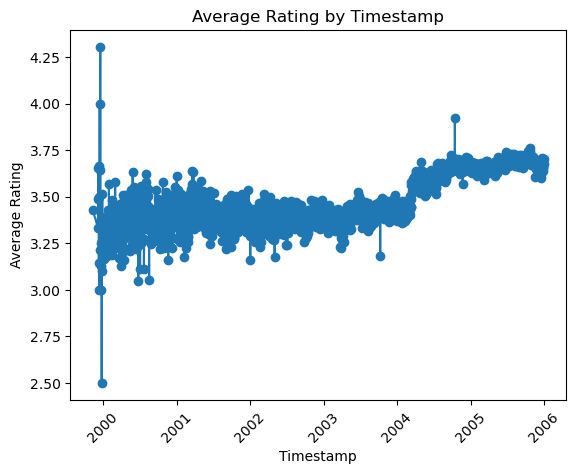

In [11]:
plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Average Rating')
plt.title('Average Rating by Timestamp')
plt.xticks(rotation=45)
plt.show()

In [76]:
class Temporal_Netflix(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = self.df['Cust_ID'].values
        self.items = self.df['Movie_Id'].values
        self.ratings = self.df['Rating'].values
        self.time = self.df['bins'].values
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        time = self.time[index]

        rating = self.ratings[index]
        
        return user, item,time, rating
    


In [97]:
train_df, test_df = train_test_split(sample_df, test_size = 0.2, random_state = 42)
train_dataset = Temporal_Netflix(train_df)
test_dataset = Temporal_Netflix(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def temporal_train(model, train_loader):
    model.train() 
    total_loss = 0 
    for user, item, time,rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        time = time.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, item,time)
        loss = criterion(pred, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    total_loss = total_loss / len(train_loader)
    
    return total_loss

def temporal_evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for user, item, time,rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            time = time.to(device)
            rating = rating.to(device)

            pred = model(user, item,time)
            loss = criterion(pred, rating)

            total_loss += loss.item()
    
    return total_loss / len(test_loader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
mu = train_df.Rating.mean()
model = TemporalDynamics(len(sample_df_user2idx), len(sample_df_item2idx), 20, mu, 72)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = RMSELoss

best_metric = 1 
summary = pd.DataFrame({'epoch':[], 'train_loss':[], 'val_loss':[]})

for epoch in range(0, 31):
    print(f'epoch: {epoch} start')
    train_loss = temporal_train(model, train_dataloader)
    val_loss = temporal_evaluate(model, test_dataloader)
    
    print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}')
    summary.loc[epoch] = [epoch, train_loss, val_loss]

epoch: 0 start
epoch: 0, train_loss: 1.3516193912949237, val_loss: 1.2367652382155627
epoch: 1 start
epoch: 1, train_loss: 1.0709007704532152, val_loss: 1.146982848126068
epoch: 2 start
epoch: 2, train_loss: 0.8640152394347018, val_loss: 1.1047740479730803
epoch: 3 start
epoch: 3, train_loss: 0.6855857753034558, val_loss: 1.0906657842704974
epoch: 4 start
epoch: 4, train_loss: 0.5589751028320366, val_loss: 1.083797739686683
epoch: 5 start
epoch: 5, train_loss: 0.4677787992898158, val_loss: 1.0810049126232268
epoch: 6 start
epoch: 6, train_loss: 0.4120798003552459, val_loss: 1.0834884612466829
epoch: 7 start
epoch: 7, train_loss: 0.37628025374537666, val_loss: 1.0770196857528695
epoch: 8 start
epoch: 8, train_loss: 0.35287616947563255, val_loss: 1.0819146243831168
epoch: 9 start
epoch: 9, train_loss: 0.33588842318216044, val_loss: 1.0749159230372016
epoch: 10 start
epoch: 10, train_loss: 0.32543230639151416, val_loss: 1.0728301828032523
epoch: 11 start
epoch: 11, train_loss: 0.315144230

KeyboardInterrupt: 